In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# all movies and shows data taken from Kaggle
# https://www.kaggle.com/datasets/dgoenrique/netflix-movies-and-tv-shows/data
df = pd.read_csv('titles.csv')
# originals data scraped off Wikipedia, code is in scraper.py
originals_df = pd.read_csv('originals.csv')
originals_df['original'] = True
originals_df['title'] = originals_df['title'].str.replace('&amp;', '&')

In [4]:
df = df.merge(right=originals_df, how='left', left_on='title', right_on='title')

In [5]:
df['original'].fillna(False, inplace=True)
df['imdb_score'].fillna(0, inplace=True)
df['imdb_votes'].fillna(0, inplace=True)
df['genres'] = df['genres'].str.replace("[", "").str.replace("]", "").str.replace("'", "")
df['production_countries'] = df['production_countries'].str.replace("[", "").str.replace("]", "").str.replace("'", "")

In [6]:
df.drop(columns=['id', 'description', 'age_certification', 'imdb_id', 'tmdb_popularity', 'tmdb_score'], inplace=True)
# One Piece from 1999 is NOT an original show
df['original'].loc[df['title'] == 'One Piece'] = False

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6151 entries, 0 to 6150
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 6151 non-null   object 
 1   type                  6151 non-null   object 
 2   release_year          6151 non-null   int64  
 3   runtime               6151 non-null   int64  
 4   genres                6151 non-null   object 
 5   production_countries  6151 non-null   object 
 6   seasons               2315 non-null   float64
 7   imdb_score            6151 non-null   float64
 8   imdb_votes            6151 non-null   float64
 9   original              6151 non-null   bool   
dtypes: bool(1), float64(3), int64(2), object(4)
memory usage: 438.6+ KB


In [8]:
df.head()

,title,type,release_year,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,original
0,Five Came Back: The Reference Films,SHOW,1945,51,documentation,US,1.0,0.0,0.0,False
1,Rocky,MOVIE,1976,119,"drama, sport",US,NaN,8.1,588100.0,False
2,Grease,MOVIE,1978,110,"romance, comedy",US,NaN,7.2,283316.0,False
3,The Sting,MOVIE,1973,129,"crime, drama, comedy, music",US,NaN,8.3,266738.0,False
4,Rocky II,MOVIE,1979,119,"drama, sport",US,NaN,7.3,216307.0,False


## Movies vs Shows distribution

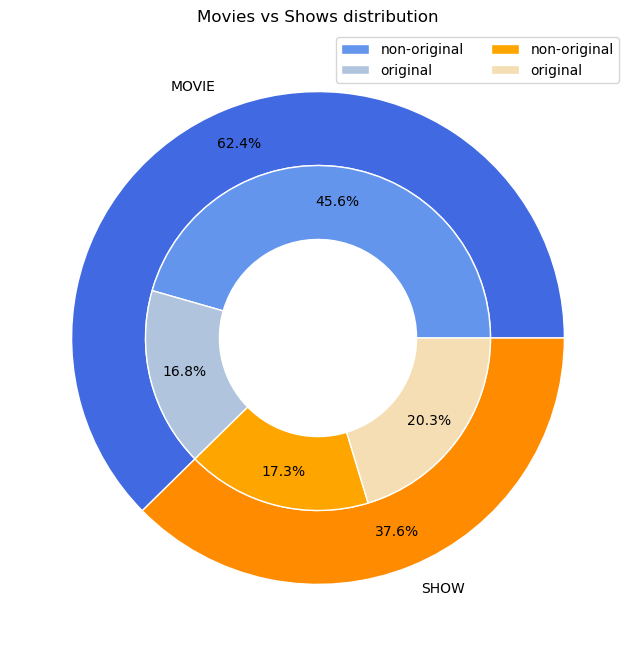

In [9]:
outer = df['type'].value_counts()
inner = df[['type', 'original']].groupby(by=['type', 'original']).value_counts()
fig, ax = plt.subplots(figsize=(16,8))
size = 0.3

ax.pie(outer.values.flatten(), radius=1,
       labels=outer.index,
       colors=['royalblue', 'darkorange'],
       autopct='%1.1f%%',
       pctdistance=0.85,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(inner.values.flatten(), radius=1-size, 
       autopct='%1.1f%%',
       pctdistance=0.8,
       colors=['cornflowerblue', 'lightsteelblue', 'orange', 'wheat'],
       wedgeprops=dict(width=size, edgecolor='w'))
ax.set(aspect="equal", title='Movies vs Shows distribution')
ax.legend(['_', '_', 'non-original', 'original', 'non-original', 'original'], loc='best', ncols=2)

plt.show()

## Shows vs movies genres distribution

In [10]:
genres = {}
original_shows_genres = {}
original_movies_genres = {}
for idx, row in df[['type', 'genres', 'original']].iterrows():
    if ',' in row[1]:
        for gen in row[1].split(', '):
            genres[gen] = genres[gen] + 1 if gen in genres.keys() else 1
            if row[0] == 'SHOW' and row[2]:
                original_shows_genres[gen] = original_shows_genres[gen] + 1 if gen in original_shows_genres.keys() else 1
            elif row[0] == 'MOVIE' and row[2]:
                original_movies_genres[gen] = original_movies_genres[gen] + 1 if gen in original_movies_genres.keys() else 1
    else:
        genres[row[1]] = genres[row[1]] + 1 if row[1] in genres.keys() else 1
        if row[0] == 'SHOW' and row[2]:
            original_shows_genres[row[1]] = original_shows_genres[row[1]] + 1 if row[1] in original_shows_genres.keys() else 1
        elif row[0] == 'MOVIE' and row[2]:
            original_movies_genres[row[1]] = original_movies_genres[row[1]] + 1 if row[1] in original_movies_genres.keys() else 1

del genres['']
del original_shows_genres['']
del original_movies_genres['']

In [11]:
genres = dict(sorted(genres.items(), key=lambda item: item[1]))
original_shows_genres = {k: original_shows_genres[k] for k in genres.keys()}
original_movies_genres = {k: original_movies_genres[k] for k in genres.keys()}

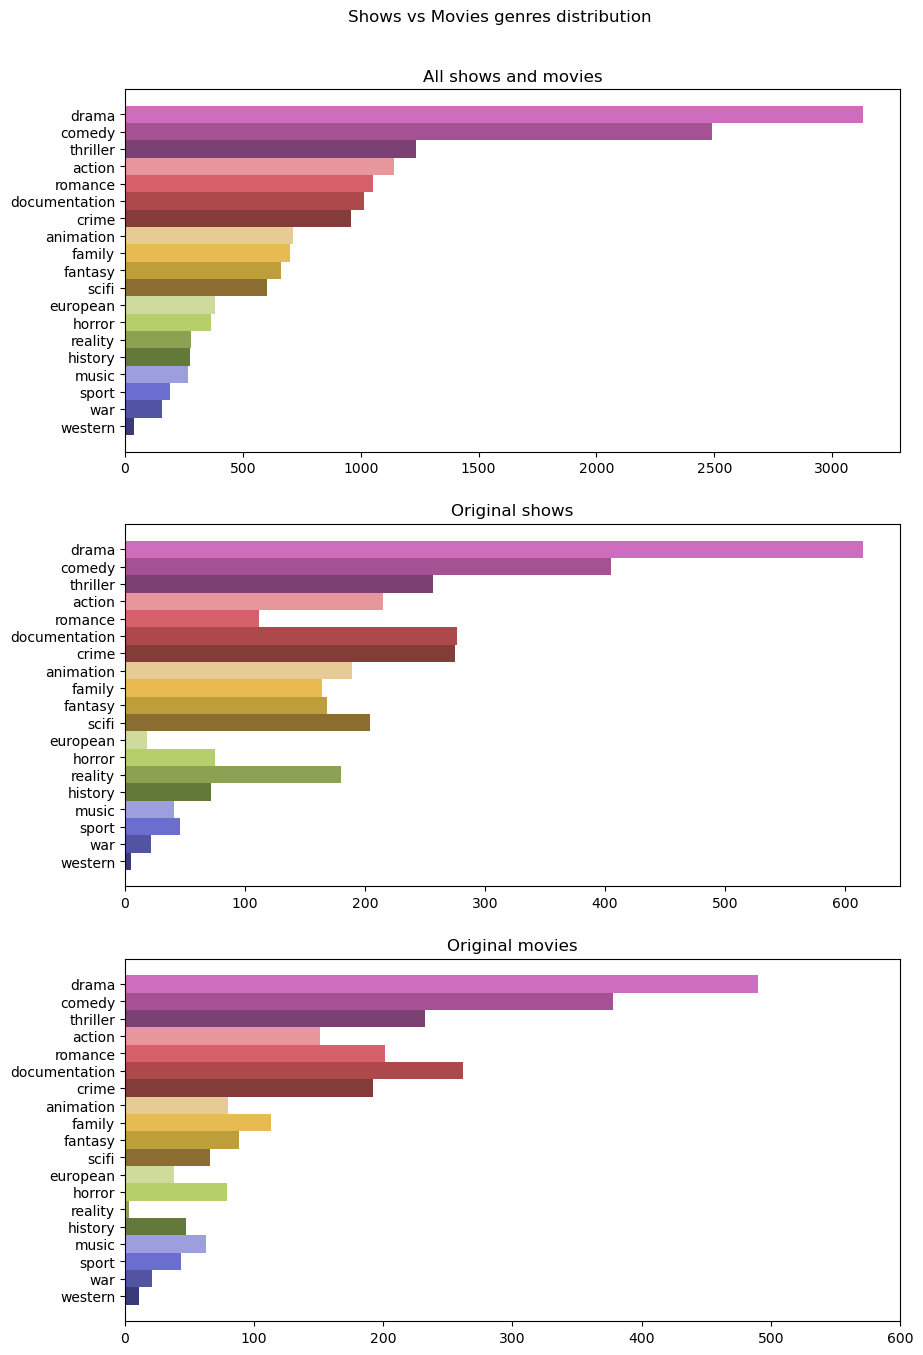

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 16))
fig.suptitle('Shows vs Movies genres distribution', y=0.93)
cmap = plt.colormaps['tab20b']
colors = cmap([i for i in range(len(genres.keys()))])

ax1.barh(list(genres.keys()), genres.values(), height=1, color=colors)
ax1.set_title('All shows and movies')

ax2.barh(list(original_shows_genres.keys()), original_shows_genres.values(), height=1, color=colors)
ax2.set_xticks([x for x in range(0, 601, 100)])
ax2.set_title('Original shows')

ax3.barh(list(original_movies_genres.keys()), original_movies_genres.values(), height=1, color=colors)
ax3.set_xticks([x for x in range(0, 601, 100)])
ax3.set_title('Original movies')

plt.show()

## Some statistics

In [13]:
# set minimum imdb_votes to skip almost unknown shows and movies
avg_duration = df[['runtime', 'type']].loc[df['original'] == True].groupby(by='type').mean()
avg_seasons = df['seasons'].loc[(df['original'] == True) & (df['type'] == 'SHOW') & (df['imdb_votes'] > 2000)].mean()
max_seasons = df['seasons'].loc[(df['original'] == True) & (df['type'] == 'SHOW')].max()
max_title = df['title'].loc[(df['seasons'] == max_seasons) & (df['original'] == True)].values[0]

avg_ratings = df[['imdb_score', 'type']].loc[(df['original'] == True) & (df['imdb_votes'] > 2000)].groupby(by='type').mean()

print(f'Average original movie duration: {round(avg_duration.iloc[0][0])} minutes.')
print(f'Average original show duration: {round(avg_duration.iloc[1][0])} minutes.\n')

print(f'Average seasons in original shows: {round(avg_seasons, 2)}')
print(f'Maximum original seasons: {int(max_seasons)} - {max_title}\n')

print(f'Average original movie rating: {round(avg_ratings.iloc[0][0], 2)}')
print(f'Average original show rating: {round(avg_ratings.iloc[1][0], 2)}')

Average original movie duration: 92 minutes.
Average original show duration: 39 minutes.

Average seasons in original shows: 1.9
Maximum original seasons: 12 - Trailer Park Boys

Average original movie rating: 6.21
Average original show rating: 7.15


### Top 3 original movies and shows

In [14]:
df[['title', 'release_year', 'imdb_score', 'type']].loc[(df['original'] == True) & (df['imdb_votes'] > 2000)].sort_values(
    by='imdb_score', ascending=False).groupby(by='type').head(3)

,title,release_year,imdb_score,type
3193,Our Planet,2019,9.3,SHOW
2668,The Last Dance,2020,9.1,SHOW
4298,Arcane,2021,9.0,SHOW
3223,David Attenborough: A Life on Our Planet,2020,8.9,MOVIE
1698,Taylor Swift: Reputation Stadium Tour,2018,8.4,MOVIE
982,Winter on Fire: Ukraine's Fight for Freedom,2015,8.3,MOVIE


## Original productions since launch

In [15]:
# Netflix started producing originals in 2011
originals = df[['release_year', 'type']].loc[(df['original'] == True) & (df['release_year'] >= 2011)]\
.groupby('type').value_counts().unstack(level=0).sort_values('release_year')
originals.fillna(0, inplace=True)
originals

type,MOVIE,SHOW
release_year,,
2011,1.0,2.0
2012,0.0,4.0
2013,0.0,3.0
2014,3.0,4.0
2015,12.0,29.0
2016,33.0,53.0
2017,69.0,68.0
2018,102.0,135.0
2019,126.0,178.0


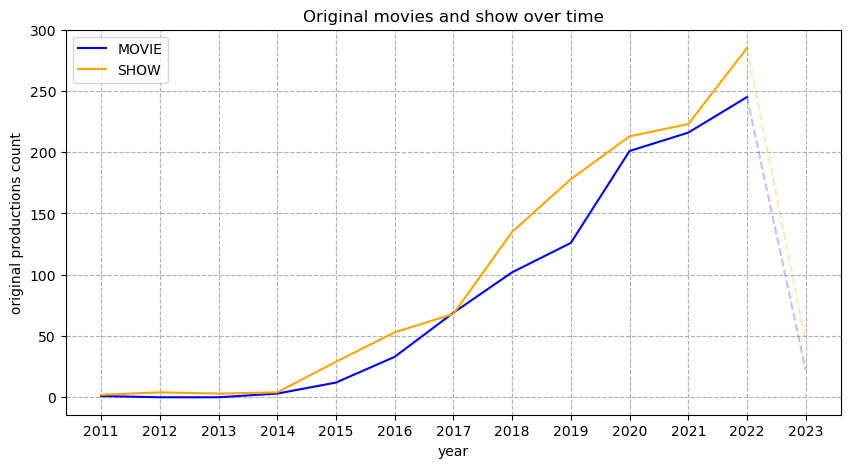

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(originals['MOVIE'].loc[originals.index <= 2022], color='blue')
ax.plot(originals['SHOW'].loc[originals.index <= 2022], color='orange')
ax.plot(originals['MOVIE'].loc[originals.index >= 2022], color='blue', alpha=.25, linestyle='--')
ax.plot(originals['SHOW'].loc[originals.index >= 2022], color='orange', alpha=.25, linestyle='--')
ax.legend(originals.columns)
ax.grid(linestyle='--')

plt.xticks(originals.index)
plt.yticks(list(plt.yticks())[0][1:])
plt.title('Original movies and show over time')
plt.xlabel('year')
plt.ylabel('original productions count')
plt.show()
# full data for 2023 is not available yet

## Region statistics

In [17]:
eu_countries = ['AT','BE','BG','HR','CY','CZ','DK','EE','FI','FR','DE','GR','HU','IE','IT','LV','LT','LU','MT','NL','PL','PT',
                'RO','SK','SI','ES','SE','IS','LI','NO','CH','AL','BA','MD','ME','MK','RS','UA','AD','BY','MC','RU','SM','GB']
asian_countries = ['CN', 'KH', 'HK', 'JP', 'LA', 'MY', 'NP', 'KP', 'PH', 'SG', 'KR', 'TW', 'VN']
a = ['AT,BE,BG']
conditions = [
    (df['production_countries'].str.contains('US')),
    (df['production_countries'].str.contains('IN')),
    (df['production_countries'].str[:2].str.contains('|'.join(eu_countries))),
    (df['production_countries'].str[:2].str.contains('|'.join(asian_countries)))
]
values = ['USA', 'India', 'Europe', 'East Asia']
df['region'] = np.select(conditions, values)
df['region'].replace('0', 'Other', inplace=True)

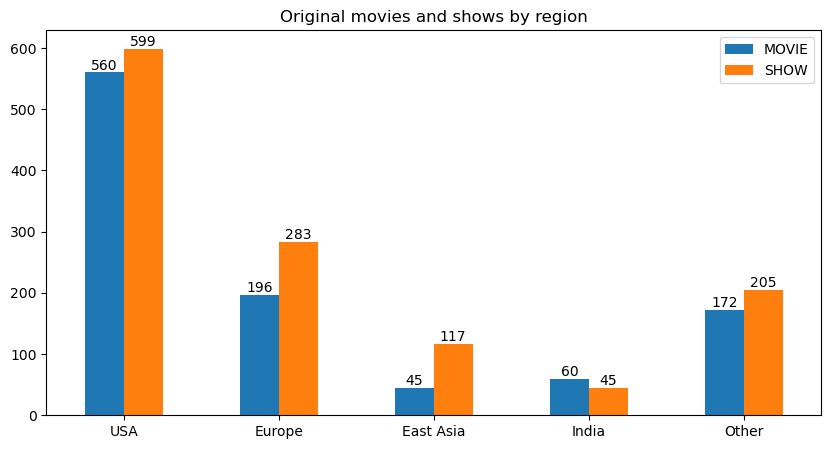

In [18]:
region_originals = df[['type', 'region']].loc[df['original'] == True].value_counts().unstack(level=0)
region_order = {'USA': 0, 'Europe': 1, 'East Asia': 2, 'India': 3, 'Other': 4}
region_originals.sort_values(by='region', key=lambda x: x.map(region_order), inplace=True)

ax = region_originals.plot(
    kind='bar',
    figsize=(10, 5),
    title='Original movies and shows by region',
    rot=0,
    xlabel=''
)
ax.legend(title='')
for container in ax.containers:
    ax.bar_label(container)

### Original shows and movies produced by region

In [19]:
regionals = df[['region', 'type', 'release_year']]\
.loc[(df['original'] == True) & (df['release_year'] >= 2011)]\
.groupby(['region']).value_counts().unstack(level=0).sort_values('release_year')
regionals.fillna(0, inplace=True)
regionals = regionals[['USA', 'Europe', 'East Asia', 'India', 'Other']]
r_movies = regionals.xs('MOVIE')
r_shows = regionals.xs('SHOW')

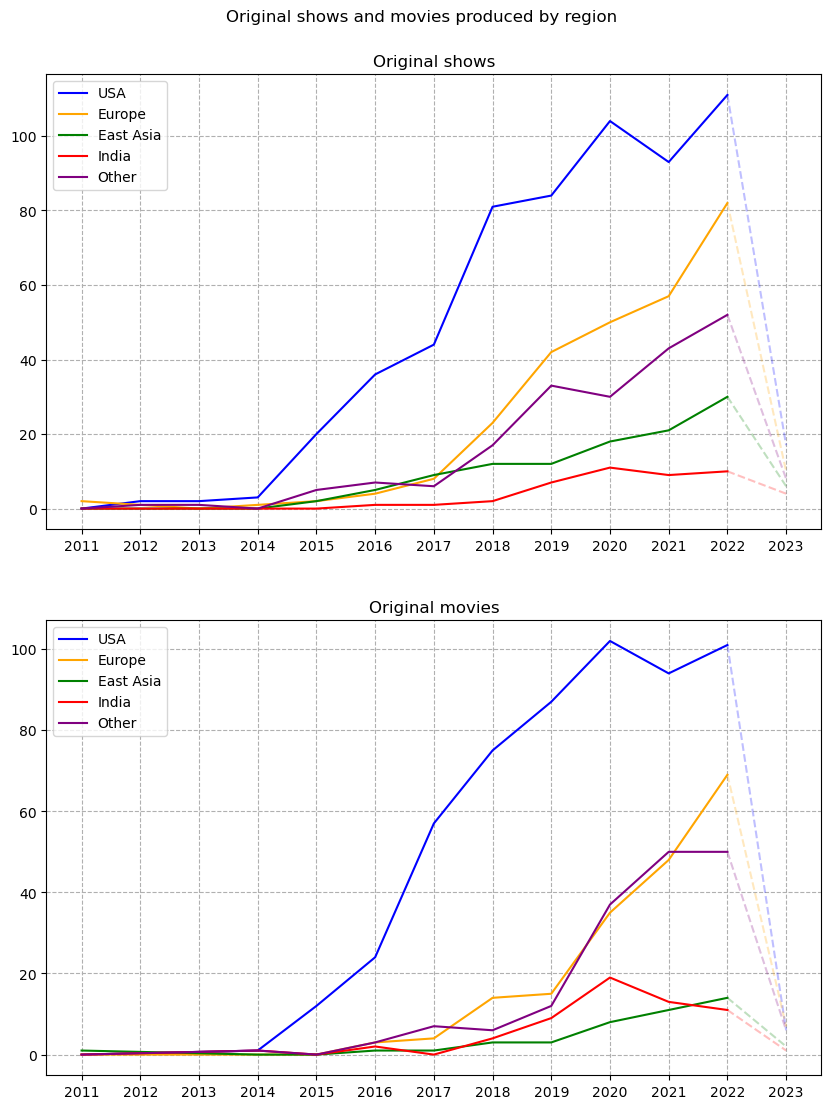

In [20]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 13))
fig.suptitle('Original shows and movies produced by region', y=0.93)

colors = ['blue', 'orange', 'green', 'red', 'purple']
for i, col in enumerate(regionals.columns):
    ax1.plot(r_shows[col].iloc[:-1], color=colors[i])
    ax1.plot(r_shows[col].iloc[-2:], color=colors[i], alpha=.25, linestyle='--')
    ax2.plot(r_movies[col].iloc[:-1], color=colors[i])
    ax2.plot(r_movies[col].iloc[-2:], color=colors[i], alpha=.25, linestyle='--')

ax1.set_xticks(r_shows.index)
ax2.set_xticks(r_shows.index)
ax1.grid(linestyle='--')
ax2.grid(linestyle='--')
ax1.set_title('Original shows')
ax2.set_title('Original movies')

leg = []
for col in regionals.columns:
    leg.append(col)
    leg.append('_')

ax1.legend(leg)
ax2.legend(leg)

plt.show()
# full data for 2023 is not available yet

### Average rating by region

In [21]:
ratings = df[['region', 'imdb_score']].loc[(df['original'] == True) & (df['imdb_votes'] > 500) & (df['release_year'] >- 2011)]\
.groupby('region').mean()
ratings

,imdb_score
region,
East Asia,6.885124
Europe,6.492982
India,6.496552
Other,6.406612
USA,6.625720


In [22]:
yearly_ratings = df[['region', 'release_year', 'imdb_score']]\
.loc[(df['original'] == True) & (df['release_year'] >= 2011)]\
.groupby(['region', 'release_year']).mean('imdb_score').round(2).unstack(level=0)
yearly_ratings.fillna(0, inplace=True)
yearly_ratings = yearly_ratings[[('imdb_score', 'USA'), ('imdb_score', 'Europe'), ('imdb_score', 'East Asia'), ('imdb_score', 'India'), ('imdb_score', 'Other')]]
yearly_ratings

imdb_score                             
region              USA Europe East Asia India Other
release_year                                        
2011               0.00   8.60      6.70  0.00  0.00
2012               7.80   7.90      0.00  0.00  6.60
2013               8.40   0.00      0.00  0.00  7.80
2014               7.58   8.00      0.00  8.10  6.70
2015               6.90   8.50      6.55  0.00  7.26
2016               6.66   7.17      7.43  5.50  5.84
2017               6.46   7.43      7.12  8.60  6.45
2018               6.35   6.54      6.17  6.50  6.15
2019               5.93   6.48      6.93  6.32  5.68
2020               5.84   5.59      4.92  5.10  4.83
2021               6.10   6.08      5.96  6.39  5.87
2022               6.13   5.86      6.47  5.32  5.65
2023               6.12   5.14      6.93  5.86  5.52

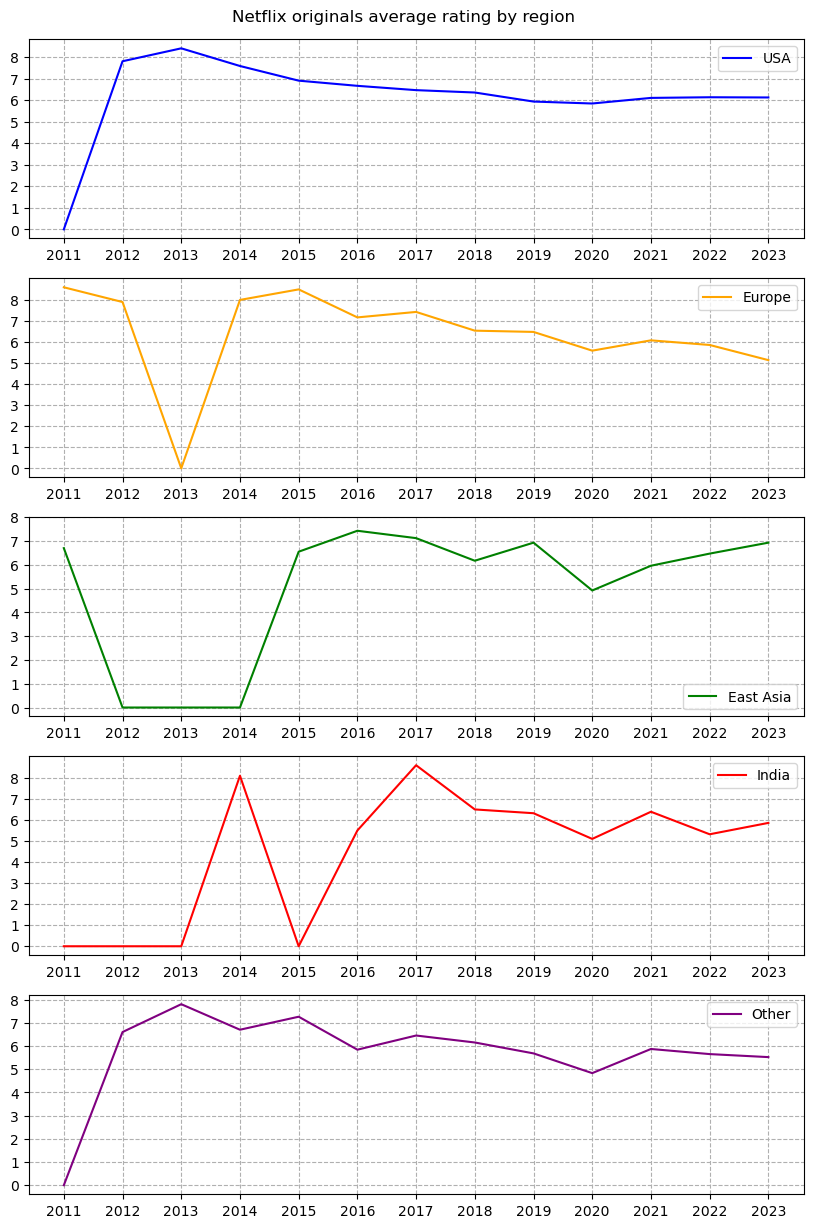

In [23]:
fig, axes = plt.subplots(5, figsize=(10, 15))
fig.suptitle('Netflix originals average rating by region', y=0.9)

colors = ['blue', 'orange', 'green', 'red', 'purple']
i = 0
for (ax, col) in zip(axes, yearly_ratings.columns):
    ax.plot(yearly_ratings[col], color=colors[i])
    ax.legend([col[1]])
    ax.set_xticks(yearly_ratings.index)
    ax.set_yticks([x for x in range(9)])
    ax.grid(linestyle='--')
    i += 1
    

plt.show()